# Electro-Optic Mach-Zehnder Modulator

In this notebook, we will design an electro-optic modulator based on the Pockels effect in a thin-film lithium niobate (TFLN) platform.
The design is based on the work of Ying Li *et al.* \[1], but using the open source [LNOI400 PDK](https://pypi.org/project/luxtelligence-lnoi400-forge/) from [Luxtelligence](https://luxtelligence.ai/).

We will start with the calculation of VπL based on the optical waveguide and transmission line cross-sections defined in the PDK [technology](../guides/Technology.ipynb).
Next, we can verify the modulation response and signal integrity of our design, and, finally, layout the full chip with coupling and reference structures.

**References**

1. Ying Li, *et al.*, “High-Performance Mach–Zehnder Modulator Based on Thin-Film Lithium Niobate with Low Voltage-Length Product,” *ACS Omega* 2023 8 (10), 9644-9651, doi: [10.1021/acsomega.3c00310](https://pubs.acs.org/doi/10.1021/acsomega.3c00310).

In [1]:
import luxtelligence_lnoi400_forge as lxt
import numpy as np
import photonforge as pf
import tidy3d as td
from matplotlib import pyplot as plt

td.config.logging_level = "ERROR"

## Design of VπL

We compute the value of VπL for the modulator we want to design to define how long we will need it to be, based on the drivers we have available.

VπL can be derived exclusively by the optical waveguide and transmission line cross-section before the actual layout.
This helps us define those cross-sections and make any required changes to the technology parameters and port specifications, if necessary.

The LNOI400 parametric technology can optionally include the substrate material when extruding components.
That option is useful to differentiate between optical and electrical simulation: the former will not depend on the substrate in most cases, so we leave it off to minimize the simulation domains.

Of course, for the VπL calculation, we need to account for the electrical field interaction with the substrate, so we include it in this first step.

In [2]:
tech = lxt.lnoi400(include_substrate=True, include_top_opening=True)
pf.config.default_technology = tech

### Optical Waveguide

We can start by taking a look at the optical waveguide we will use.
It is a wide multimode rib that is used for phase shifters and electro-optic modulators to reduce optical losses.

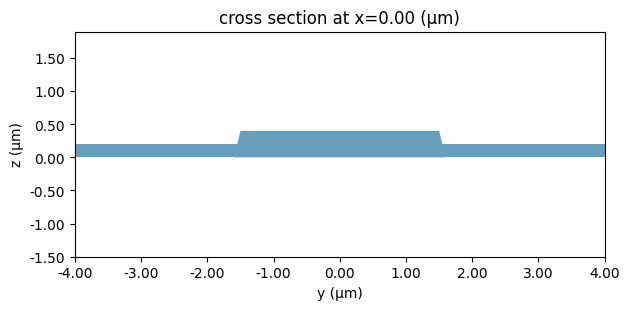

In [3]:
lda = 1.55
wg_spec = tech.ports["RWG3000"]

_ = pf.tidy3d_plot(wg_spec, frequency=pf.C_0 / lda)

Loading cached simulation from .tidy3d/pf_cache/5LR/ms_info-5ZLWCSW3WPHA6C7SHTWLEHF7PRB2ZLUTXZSWI7V7JKFAORBZ5Y3Q.json.


wavelength     n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                  
1.934145e+14 0                 1.55  1.851404    0.0          0.999715   
             1                 1.55  1.813566    0.0          0.997999   
             2                 1.55  1.762824    0.0          0.004851   
             3                 1.55  1.752917    0.0          0.978302   
             4                 1.55  1.722247    0.0          0.030663   

                         wg TE fraction  wg TM fraction  mode area  \
f            mode_index                                              
1.934145e+14 0                 0.988352        0.869537   1.393297   
             1                 0.955362        0.874249   1.535248   
             2                 0.775278        0.987709   2.167908   
             3                 0.908936        0.881834   1.840003   
             4                 0.785371        0.951461   2.258016   

                         group index  dispersion (ps/(nm km))  
f            mode_index                                        
1.934145e+14 0              2.203465              -472.857368  
             1              2.235841              -472.857368  
             2              2.315979             -1366.032396  
             3              2.277045              -499.127222  
             4              2.346057             -1523.651519

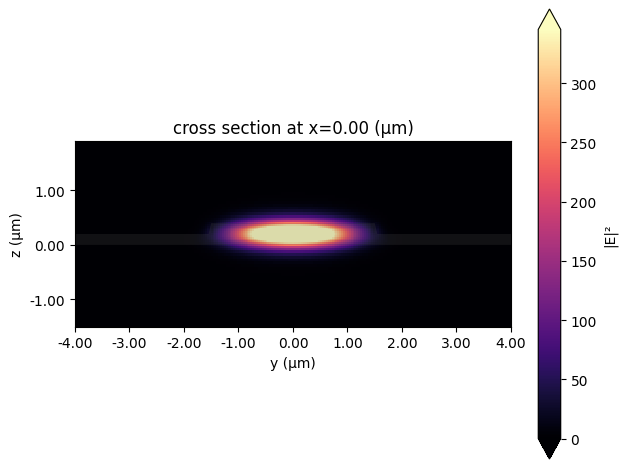

In [4]:
opt_solver = pf.port_modes(wg_spec, [pf.C_0 / lda], group_index=True)

_ = opt_solver.plot_field("E", "abs^2", mode_index=0)

opt_solver.data.to_dataframe()

We see that this waveguide supports many modes, but we're interested in the TE-like fundamental model (with `mode_index == 0`) with an effective index of 1.85 and group index of 2.20.

The design of a high-bandwidth electro-optic modulator with a low driving voltage requires careful simulation and a thorough understanding of the associated trade-offs.
One critical factor is velocity matching between RF and optical signals.
To achieve this, the RF transmission lines must be engineered so that the co-propagating optical and electrical signals travel at similar speeds (RF phase velocity close to the optical group velocity).

Another key consideration is the electrode geometry: narrower electrode gaps are necessary to generate a stronger electric field in the waveguide region, thereby enhancing the electro-optic modulation efficiency.
However, the transmission line impedance must closely match the source impedance (typically 50 Ohms) to ensure efficient delivery of electrical signals with minimal losses.
Achieving an optimized design typically involves iterating on the electrode geometry, optical etch depths, and the thicknesses and materials of the layer stack.

### Coplanar Waveguide

Next, we will take a closer look at the RF transmission line cross-section we will be using.

We start with a simple transmission line without the waveguide in between the metal gap.
The transmission line is a co-planar waveguide (CPW) geometry with 10 μm wide signal, 4 μm wide gap, and 180 μm wide ground line from the Foundry PDK itself.

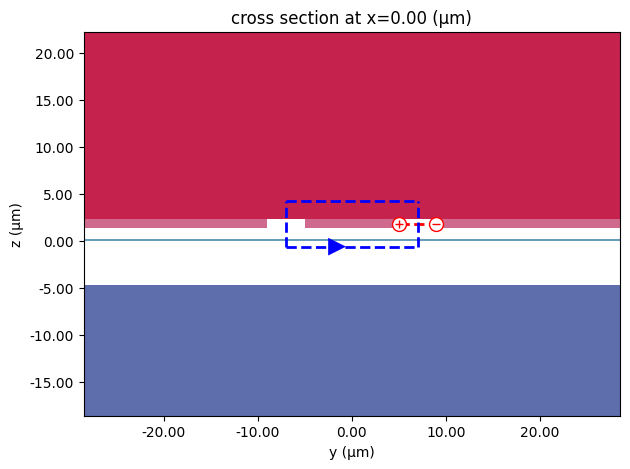

In [5]:
# Define RF frequency range from 1 GHz to 65 GHz
rf_freqs = np.linspace(1e9, 65e9, 20)

cpw_spec = tech.ports["UniCPW-EO"]
ax = pf.tidy3d_plot(cpw_spec, frequency=rf_freqs[0])

ic = cpw_spec.to_tidy3d_impedance_calculator()
_ = ic.voltage_integral.plot(ax=ax, x=0)
_ = ic.current_integral.plot(ax=ax, x=0)

Analogously to the optical waveguide, we can easily calculate the CPW mode:

Loading cached simulation from .tidy3d/pf_cache/FEM/ms_info-2QCGQ7GWQUHEOBK2J7WJBYWJWDKH4GBR6GBTTF5GP6RKJQPKOPVQ.json.


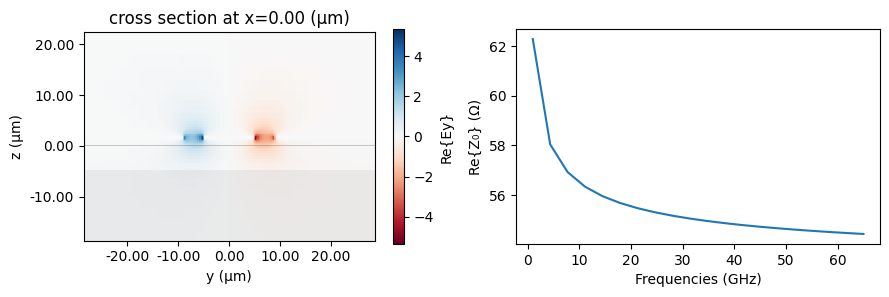

In [6]:
cpw_solver, z0 = pf.port_modes(cpw_spec, rf_freqs, impedance=True)

fig, ax = plt.subplots(1, 2, figsize=(9, 3), tight_layout=True)

cpw_solver.plot_field("Ey", "real", f=rf_freqs[0].item(), robust=False, ax=ax[0])

ax[1].plot(z0.f * 1e-9, z0.real)
_ = ax[1].set(xlabel="Frequencies (GHz)", ylabel="Re{Z₀} (Ω)")

### Computation of Vπ·L

PhotonForge allows us to combine both waveguide cross-sections to evaluate how effectively we can use the Pockels effect in this geometry to induce a phase shift in the MZM arm from the applied voltage.
By running RF and optical simulations directly with all cross-perturbations included, PhotonForge allows designers to explore various trade-offs encountered when trying to design a high-bandwidth modulator with a low driving voltage.

We look at the path profiles of the CPW to get the gap and offset from the conductors:

In [7]:
cpw_paths = cpw_spec.path_profiles
cpw_paths

{'gnd1': (180.0, 99.0, (21, 0)),
 'gnd0': (180.0, -99.0, (21, 0)),
 'signal': (10.0, 0.0, (21, 0))}

In [8]:
ground_width, ground_offset, _ = cpw_paths["gnd1"]
signal_width, _, _ = cpw_paths["signal"]
offset = (ground_offset - ground_width / 2 + signal_width / 2) / 2
gap = ground_offset - ground_width / 2 - signal_width / 2

print(f"Offset: {offset} μm\nGap: {gap} μm")

Offset: 7.0 μm
Gap: 4.0 μm


Now we combine the CPW with 2 optical waveguide profiles at the appropriate offsets:

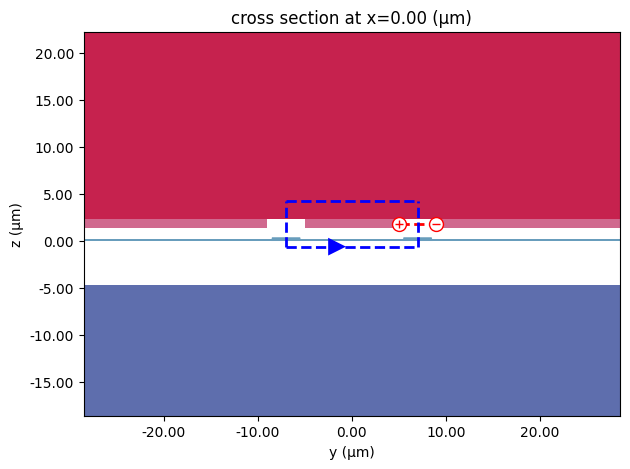

In [9]:
mzm_spec = cpw_spec.combined_with(wg_spec, offset).combined_with(wg_spec, -offset)

ax = pf.tidy3d_plot(mzm_spec, frequency=rf_freqs[0])
ic.voltage_integral.plot(ax=ax, x=0)
_ = ic.current_integral.plot(ax=ax, x=0)

We solve again for the electric field profile, but we add mesh override structures to make sure the RF field is finely resolved in the optical waveguide region.
To do so, we manually export the mode solver and update it with the desired overrides.

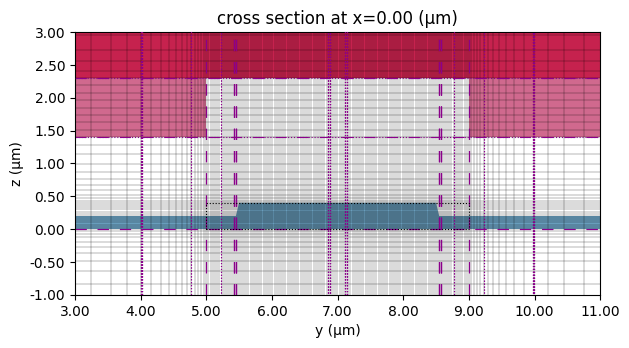

In [10]:
# Get the minimal grid spacing from the optical simulation to use here as well
dy = np.diff(opt_solver.simulation.grid.boundaries.z).min()
dz = np.diff(opt_solver.simulation.grid.boundaries.z).min()

# Mesh override parameters
dl = (None, dy, dz)
ln_thickness = tech.parametric_kwargs["ln_thickness"]
size = (td.inf, gap, ln_thickness)

mzm_solver = mzm_spec.to_tidy3d(frequencies=rf_freqs)
mzm_solver = mzm_solver.updated_copy(
    "simulation/grid_spec",
    override_structures=[
        td.MeshOverrideStructure(
            geometry=td.Box(center=(0, -offset, ln_thickness / 2), size=size), dl=dl
        ),
        td.MeshOverrideStructure(
            geometry=td.Box(center=(0, offset, ln_thickness / 2), size=size), dl=dl
        ),
    ],
)
ax = mzm_solver.plot()
mzm_solver.plot_grid(ax=ax)
_ = ax.set(xlim=(offset - 4, offset + 4), ylim=(-1, 3))

In the field plot we can clearly see the effects of the dielectric waveguides. We care about the `Ey` field component (the one aligned to z crystal axis in the X-cut LiNbO₃), because this field results in index change along z crystal axis due to large electro-optic coefficient ($r_{33}$).

Loading cached simulation from .tidy3d/pf_cache/OA5/ms_info-RYZ3DMM37N3OPUOJQYYH2OINDIHFVRPBKKBHL4X37NFBUCULY75A.json.


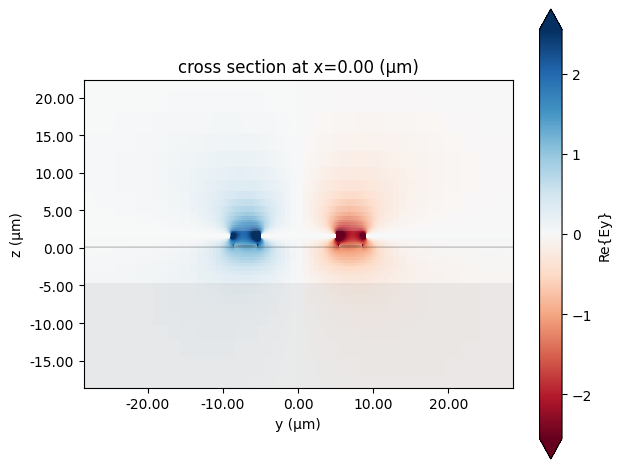

In [11]:
mzm_solver = pf.port_modes(mzm_solver)

_ = mzm_solver.plot_field("Ey", "real", f=rf_freqs[0].item(), robust=True)

We are also interested in the characteristics for the MZM cross-section, readily available from the mode solver data and the impedance calculator from before.
Note that we cannot use the argument ``impedance=True`` in [port_modes](../_autosummary/photonforge.port_modes.rst) because we are passing a Tidy3D mode solver to it, not a [port](../_autosummary/photonforge.Port.rst) or [port specification](../_autosummary/photonforge.PortSpec.rst), and the mode solver does not contain the required information to calculate the impedance.

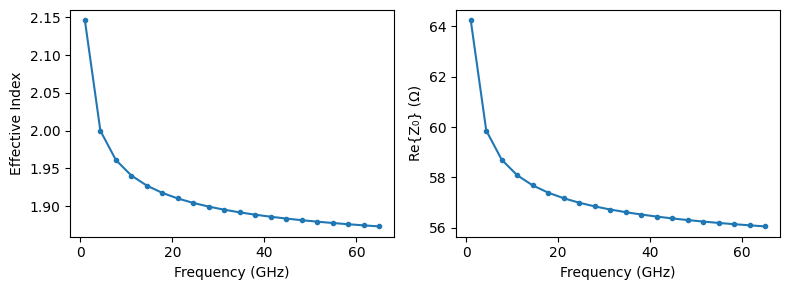

In [12]:
n_eff = mzm_solver.data.n_eff.isel(mode_index=0).values
z0 = ic.compute_impedance(mzm_solver.data)

fig, ax = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True)

ax[0].plot(rf_freqs * 1e-9, n_eff, ".-")
ax[0].set(ylabel="Effective Index", xlabel="Frequency (GHz)")

ax[1].plot(rf_freqs * 1e-9, np.real(z0), ".-")
_ = ax[1].set(ylabel="Re{Z₀} (Ω)", xlabel="Frequency (GHz)")

These results match closely the experimental data measured by the foundry at 65 GHZ: effective index around 1.88 and characteristic impedance of 55.6 Ω.

We will use the electrical field in the direction of the LiNbO₃ cut in this platform to perturb the optical medium.
To do so, we first need to normalize the field by the voltage and offset its coordinates to match the optical simulation, where the dielectric waveguide is centered around y=0.

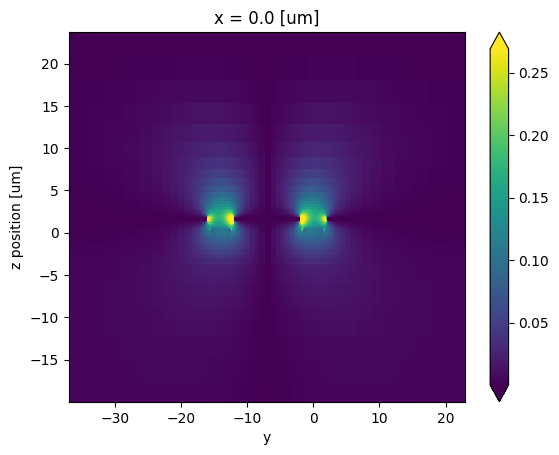

In [13]:
v0 = ic.voltage_integral.compute_voltage(mzm_solver.data)

ey_norm = (mzm_solver.data.Ey / v0).isel(f=0, mode_index=0, drop=True).abs
ey_norm = ey_norm.assign_coords(y=ey_norm.y - offset)

ey_norm.isel(x=0).transpose("z", "y").plot(robust=True)
# _ = plt.gca().set(xlim=(-gap, gap), ylim=(-1, 4))

The normalized electrical field is used to perturb the LiNbO₃ in the z axis of the crystal according to the Pockels effect model:

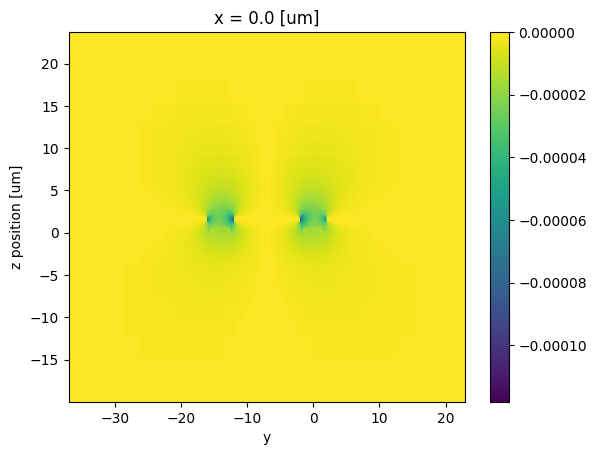

In [14]:
ln = td.material_library["LiNbO3"]["Zelmon1997"](optical_axis=1)
eps_o, eps_e, _ = (e.real for e in ln.eps_diagonal(pf.C_0 / lda))

n_e = eps_e**0.5
r33 = 30.9e-6  # μm/V

# Index variation derived from the RF field
Δn = -0.5 * n_e**3 * r33 * ey_norm

# We plot the whole domain, but the perturbation will only take effect over the LiNbO₃, not everywhere
_ = Δn.isel(x=0).transpose("z", "y").plot(robust=False)

We can create a small function that generates the perturbed medium depending on the voltage and calculates the modes.
The perturbed medium is created as a custom anisotropic medium from Tidy3D:

In [15]:
# Use a single data point for the homogeneous directions
eps_o_array = td.SpatialDataArray(
    np.full((1, 1, 1), eps_o), coords={"x": [0], "y": [0], "z": [0]}
)


def perturbed_solver(voltage):
    perturbed_ln = td.CustomAnisotropicMedium(
        xx=td.CustomMedium(permittivity=eps_o_array, subpixel=True),
        yy=td.CustomMedium(permittivity=(n_e + voltage * Δn) ** 2, subpixel=True),
        zz=td.CustomMedium(permittivity=eps_o_array, subpixel=True),
    )
    # We use the same optical waveguide as before and change the LiNbO₃ medium in the technology
    return pf.port_modes(
        wg_spec, [pf.C_0 / lda], technology=lxt.lnoi400(ln=perturbed_ln)
    )

We calculate the effective index for a few voltage values to derive Vπ·L:

Loading cached simulation from .tidy3d/pf_cache/M2B/ms_info-ZATUZRNCKHGYMI7G22FNBXLLN3RJWOM2MLPELZ7RZAAMFM35OCDA.json.


Loading cached simulation from .tidy3d/pf_cache/IE2/ms_info-KLXOP67XS4DJG6KXEQMSO2BY3U2MZYV6ZLY6KJLYCIWFEES6BQAQ.json.


Loading cached simulation from .tidy3d/pf_cache/P2F/ms_info-52WK34TTE25CTKLE54KGCEWWXAMDXRW5OBB37LDNXL7PFXOTZSKQ.json.


Loading cached simulation from .tidy3d/pf_cache/PA6/ms_info-SE2AL4VJIX3XYTOKYAFB234VFDPP4JEMRYED6WT5VLG3QC6STQRQ.json.


Loading cached simulation from .tidy3d/pf_cache/FWV/ms_info-AGCOBVYFYHJAFDLNXOUVQIJ6HAI5HZ3IIZOULMGOADZLS5WJOB4Q.json.
Vπ·L (single-drive) = 5.58 V·cm
Vπ·L (push-pull)    = 2.79 V·cm


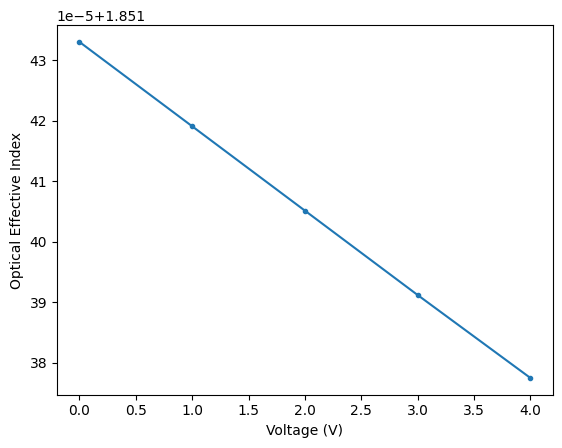

In [16]:
voltages = np.arange(5)
n_eff = [
    perturbed_solver(v).data.n_eff.isel(mode_index=0, f=0).item() for v in voltages
]

_ = plt.plot(voltages, n_eff, ".-")
plt.gca().set(xlabel="Voltage (V)", ylabel="Optical Effective Index")

# The variation is quite linear, so we simply use the largest interval
dneff_dV = abs(n_eff[-1] - n_eff[0]) / (voltages[-1] - voltages[0])

vpil = 0.5 * lda / dneff_dV  # in V·μm"

print(f"Vπ·L (single-drive) = {vpil * 1e-4:.2f} V·cm")
print(f"Vπ·L (push-pull)    = {vpil * 1e-4 / 2:.2f} V·cm")

Finally, we can also include the penalty for impedance mismatch and voltage scaling to Vπ·L:

In [17]:
z_load = 50  # Ω
z0_low_freq = z0.isel(f=0).real.item()

vpil_mismatch = vpil * (2 * z0_low_freq) / (z0_low_freq + z_load)

print(f"Mismatched Vπ·L (single-drive) = {vpil_mismatch * 1e-4:.2f} V·cm")
print(f"Mismatched Vπ·L (push-pull)    = {vpil_mismatch * 1e-4 / 2:.2f} V·cm")

Mismatched Vπ·L (single-drive) = 6.28 V·cm
Mismatched Vπ·L (push-pull)    = 3.14 V·cm


## Chip Layout

After the initial design, we can create the full Mach-Zehnder modulator chip layout.
As mentioned before, the optical simulations do not require the substrate present, so we reset the default technology without it.

In [18]:
opt_tech = lxt.lnoi400()
pf.config.default_technology = opt_tech

# Single mode waveguide as default
routing_spec = opt_tech.ports["RWG1000"]
pf.config.default_kwargs = {"radius": 70, "port_spec": routing_spec}

freqs = td.frequencies.c_band()

In [19]:
from photonforge.live_viewer import LiveViewer

viewer = LiveViewer()

Starting live viewer at http://localhost:5001


### Mach-Zehnder Arms

The CPW will need to be contacted on both ends using GSG (ground-signal-ground) pads.
They can be created from electrical terminals:

In [20]:
@pf.parametric_component()
def gsg_pad(*, pad_size=(100, 100), pad_gap=50):
    c = pf.Component()
    c.add_terminal(
        pf.Terminal(
            "TL", pf.Rectangle(center=(0, -pad_size[1] - pad_gap), size=pad_size)
        ),
        "G0",
    )
    c.add_terminal(pf.Terminal("TL", pf.Rectangle(center=(0, 0), size=pad_size)), "S")
    c.add_terminal(
        pf.Terminal(
            "TL", pf.Rectangle(center=(0, pad_size[1] + pad_gap), size=pad_size)
        ),
        "G1",
    )
    return c


pad = gsg_pad()
viewer(pad)

The MZM arms are built from parametric straight sections, and the pads are routed using tapers to the CPW terminals:

In [21]:
@pf.parametric_component()
def mzm_arms(*, length=3000, taper_length=150):
    c = pf.Component()

    tline = c.add_reference(pf.parametric.straight(port_spec=cpw_spec, length=length))

    cpw_paths = cpw_spec.path_profiles
    width_gnd, offset_gnd, _ = cpw_paths["gnd1"]
    width_sig, _, _ = cpw_paths["signal"]
    offset = (offset_gnd - width_gnd / 2 + width_sig / 2) / 2

    opt_wg = pf.parametric.straight(length=length, port_spec=wg_spec)
    bot_arm = c.add_reference(opt_wg).translate((0, -offset))
    top_arm = c.add_reference(opt_wg).translate((0, offset))

    c.add_port([bot_arm["P0"], top_arm["P0"], bot_arm["P1"], top_arm["P1"]])

    pad0 = c.add_reference(pad)
    pad1 = c.add_reference(pad)
    pad0.x_max = tline.x_min - taper_length
    pad1.x_min = tline.x_max + taper_length

    c.add_terminal(
        {
            f"{name}:{suffix}": pad[name]
            for pad, suffix in [(pad0, "in"), (pad1, "out")]
            for name in ("G0", "G1", "S")
        }
    )

    c.add(
        pf.parametric.route_taper(
            terminal1=pad0["G0"], terminal2=tline["E0"].terminals("gnd0")
        ),
        pf.parametric.route_taper(
            terminal1=pad0["S"], terminal2=tline["E0"].terminals("signal")
        ),
        pf.parametric.route_taper(
            terminal1=pad0["G1"], terminal2=tline["E0"].terminals("gnd1")
        ),
        pf.parametric.route_taper(
            terminal1=pad1["G0"], terminal2=tline["E1"].terminals("gnd0")
        ),
        pf.parametric.route_taper(
            terminal1=pad1["S"], terminal2=tline["E1"].terminals("signal")
        ),
        pf.parametric.route_taper(
            terminal1=pad1["G1"], terminal2=tline["E1"].terminals("gnd1")
        ),
    )

    return c


arms = mzm_arms()
viewer(arms)

### Taper

The waveguide used for routing is single mode, but the MZM arms use a multimode cross-section.
Designing the taper between then is as easy as instancing a parametric component and fine-tuning the total length.
Here we use a short section, but the simulation results show low enough insertion loss for this example.

In [22]:
taper = pf.parametric.transition(port_spec1=routing_spec, port_spec2=wg_spec, length=20)
viewer(taper)

Loading cached simulation from .tidy3d/pf_cache/5YD/fdtd_info-RY3UURB3MA3BTYLB7L56Z7L3NPGXEBJ7SYOKHO4EINUDRAN4PH2A.json.


Progress: 100% 


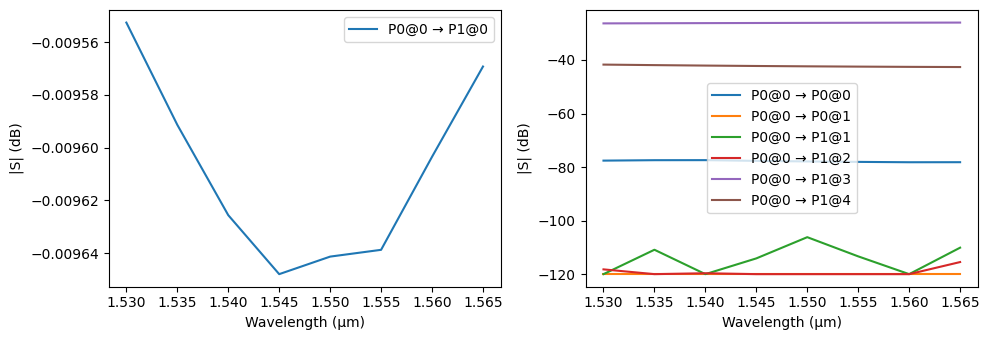

In [23]:
_ = pf.plot_s_matrix(
    taper.s_matrix(frequencies=freqs, model_kwargs={"inputs": ["P0@0"]}), y="dB"
)

### Y Spliter

The phase-shifter arms from the MZM are accessed by Y splitters in our design, so we also need to design it.

A simple S bend-based geometry can be used if the absolute lowest loss is not required:

In [24]:
@pf.parametric_component()
def y_splitter(*, s_offset, taper_length=25):
    c = pf.Component()

    core_width, _ = routing_spec.path_profile_for("LN_RIDGE")

    s_length = pf.s_bend_length(s_offset)

    for width, offset, layer in routing_spec.path_profiles:
        input_taper = pf.Path((0, 0), width, offset=offset)
        input_taper.segment((taper_length, 0), width + core_width)

        bottom_arm = pf.Path((taper_length, -0.5 * core_width), width, offset=offset)
        bottom_arm.s_bend((taper_length + s_length, -s_offset))

        top_arm = pf.Path((taper_length, 0.5 * core_width), width, offset=offset)
        top_arm.s_bend((taper_length + s_length, s_offset))

        # Heal the narrow regions for minimal feature size of approximately 100 nm
        path_list = pf.heal(
            [input_taper, bottom_arm, top_arm], 0.1 + pf.config.tolerance
        )

        c.add(layer, *path_list)

    # Add ports
    c.add_port(c.detect_ports([routing_spec]))

    # Add a model
    c.add_model(pf.Tidy3DModel(), model_name="Tidy3D")

    return c


s_offset = 0.5 * (arms.ports["P1"].center[1] - arms.ports["P0"].center[1])
splitter = y_splitter(s_offset=s_offset)
viewer(splitter)

We can easily simulate it in Tidy3D over the C band.
Before simulating, we add a field monitor so that we can visualize the simulated fields.

Note that the grid specification and shutoff arguments are given to reduce the simulation size at the cost of convergence.
These should be removed if accurate results are needed.

In [25]:
# create a monitor
field_xy = td.FieldMonitor(
    name="field_xy",
    center=(0, 0, 0.2),
    size=(td.inf, td.inf, 0),
    freqs=[freqs[len(freqs) // 2]],
)

# update the Tidy3DModel to add monitors
_ = splitter.models["Tidy3D"].update(monitors=[field_xy])

In [26]:
s_matrix = splitter.s_matrix(frequencies=freqs, model_kwargs={"inputs": ["P0@0"]})

Loading cached simulation from .tidy3d/pf_cache/6IE/fdtd_info-4JYYXKYQRSKJTJQUPZV4AWV3R6JRZNCLG3BX4DCOQF27ZD7EIYNQ.json.


Progress: 100% 


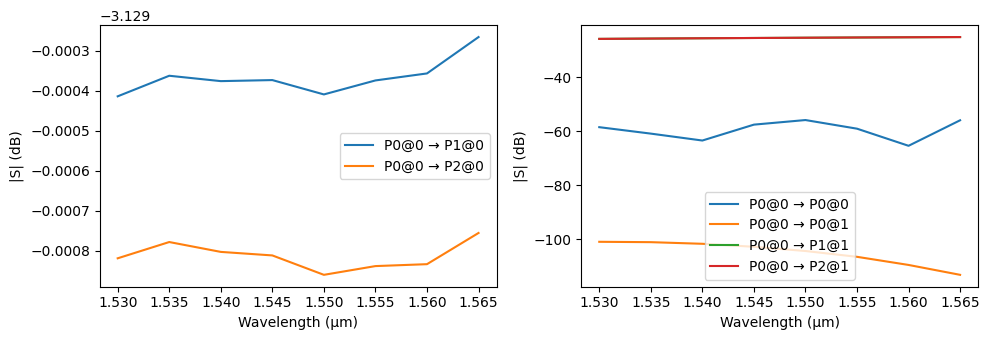

In [27]:
_ = pf.plot_s_matrix(s_matrix, y="dB")

In [28]:
sim_data = splitter.models["Tidy3D"].batch_data_for(splitter)
sim_data.task_ids

{'P0@0': 'fdve-98366ff8-d68a-461e-ac1d-1ab360bd44a4'}

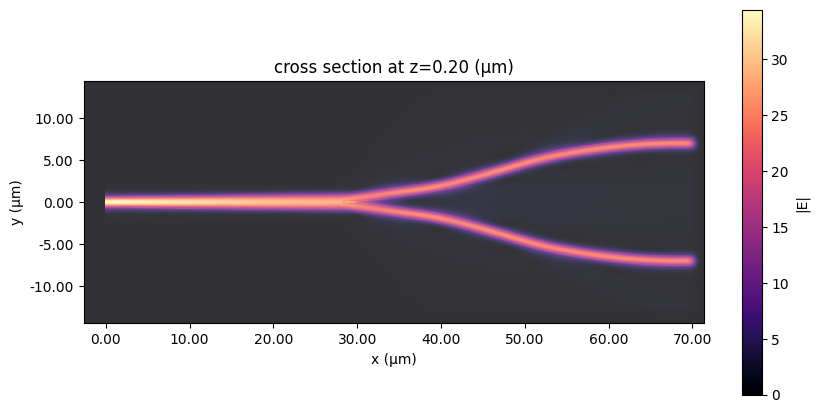

In [29]:
# visualize the fields
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
_ = sim_data["P0@0"].plot_field("field_xy", "E", "abs", robust=False, ax=ax)

### EO-MZM

Now add the splitters to the phase shifter arms to create the Mach-Zehnder interferometer, with an offset to separate both:

In [30]:
@pf.parametric_component()
def eo_mzm():
    netlist = {
        "instances": {
            "y_in": splitter,
            "y_out": splitter,
            "arms": arms,
            "taper_in0": taper,
            "taper_in1": taper,
            "taper_out0": taper,
            "taper_out1": taper,
        },
        "connections": [
            (("taper_in0", "P0"), ("y_in", "P1")),
            (("taper_in1", "P0"), ("y_in", "P2")),
            (("arms", "P0"), ("taper_in0", "P1")),
            (("taper_out0", "P1"), ("arms", "P2")),
            (("taper_out1", "P1"), ("arms", "P3")),
            (("y_out", "P1"), ("taper_out1", "P0")),
        ],
        "ports": [
            ("y_in", "P0"),
            ("y_out", "P0"),
        ],
        "models": [(pf.CircuitModel(), "Circuit")],
    }

    return pf.component_from_netlist(netlist)


mzm = eo_mzm()
viewer(mzm)

### Edge Coupler

The original work \[1] uses a simple transition to a 2.5 μm-wide waveguide at the chip edges to couple to lensed fibers.

Optimizing the length and tapering profile of such a device can be easily done within PhotonForge using, e.g. Monte Carlo sweeps.
An example of design can be found in our edge coupler notebook.

For the purpose of this example, we will simply use a PDK-provided edge coupler.

In [31]:
edge_coupler = lxt.component.double_linear_inverse_taper()
viewer(edge_coupler)

### Full Chip

We integrate the edge couplers with the MZM and create a complete device for testing.
As a reference, we should also create a straight waveguide link to evaluate the coupling losses.
These components are created by a single parametric function to improve consistency:

In [32]:
@pf.parametric_component()
def coupled_device(*, full_length=4000, coupler_length=20, reference_link=False):
    c = pf.Component()

    in_coupler = pf.Reference(edge_coupler)
    out_coupler = pf.Reference(edge_coupler, origin=(full_length, 0), rotation=180)
    c.add(in_coupler, out_coupler)

    if reference_link:
        c.add(pf.parametric.route(port1=in_coupler["P1"], port2=out_coupler["P1"]))
    else:
        mzm_ref = c.add_reference(mzm)
        mzm_ref.x_mid = full_length / 2

        if mzm_ref["P0"].center[0] < in_coupler["P1"].center[0]:
            raise RuntimeError("Device not long enough for the desired MZM.")

        c.add(
            pf.parametric.route(port1=in_coupler["P1"], port2=mzm_ref["P0"]),
            pf.parametric.route(port1=out_coupler["P1"], port2=mzm_ref["P1"]),
        )

    c.add_port([in_coupler["P0"], out_coupler["P0"]])

    c.add_model(pf.CircuitModel(), "Circuit")

    return c


device = coupled_device()
viewer(device)

In [33]:
coupled_device(reference_link=True)

Finally, the full chip layout is created with a number of repetitions of the design and reference link devices.
We also add a chip contour using the envelope function.

In [34]:
num_devices = 3
io_gap = 250

main = pf.Component("MAIN")
main.add(
    pf.Reference(
        coupled_device(reference_link=True),
        rows=num_devices,
        spacing=(0, 2 * io_gap),
    ),
    pf.Reference(
        coupled_device(),
        origin=(0, io_gap),
        rows=num_devices,
        spacing=(0, 2 * io_gap),
    ),
)

# Contour
contour = pf.envelope(
    main, offset=io_gap, use_box=True, trim_x_min=True, trim_x_max=True
)
main.add("CHIP_CONTOUR", contour)

# Labels
label_gap = 30
x_end = contour.x_max - label_gap
for i in range(num_devices):
    main.add(
        "LABELS",
        *pf.text(f"REF {i+1} A", 20, origin=(label_gap, label_gap + io_gap * 2 * i)),
        *pf.text(
            f"MZM {i+1} A", 20, origin=(label_gap, label_gap + io_gap * (1 + 2 * i))
        ),
        *pf.text(
            f"REF {i+1} B",
            20,
            origin=(x_end, -label_gap + io_gap * 2 * i),
            rotation=180,
        ),
        *pf.text(
            f"MZM {i+1} B",
            20,
            origin=(x_end, -label_gap + io_gap * (1 + 2 * i)),
            rotation=180,
        ),
    )

viewer(main)

Besides generating the GDSII layout for fabrication, we can also store the full design in a phf file to keep track of the technology specifications, ports and models in the design, not only its geometry.

In [35]:
main.write_gds("EO-MZM.gds")
pf.write_phf("EO-MZM.phf")